<a href="https://colab.research.google.com/github/seraogianluca/mircv-exercises/blob/main/Exercise4_copia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Student: Gianluca Serao
#MIRCV 2021
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install opencv-python==4.4.0.46

In [3]:
import cv2
import numpy as np
from PIL import Image
from IPython.display import display, clear_output
from imutils.video import VideoStream, FileVideoStream


BASE_DIR = '/content/gdrive/My Drive/mircv2021'
IMG_DIR = BASE_DIR + '/data/lf_img'

THRESHOLD = 35
MIN_GOOD_MATCHES = 15

In [4]:
def display_img(img, is_bgr=True):
  if is_bgr:  # convert color from CV2 BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
  display(Image.fromarray(img))
  clear_output(wait=True)

In [5]:
#TODO
img = cv2.imread(IMG_DIR + '/figure-at-a-window.jpg')

#Initialize ORB
orb = cv2.ORB_create(1000)

#Extract ORB keypoints and features from img
kp, des = orb.detectAndCompute(img,mask=None)

print(kp[0].pt)
print(kp[0].size)
print(kp[0].angle)
print(kp[0].response)
print(kp[0].octave)
print(kp[0].class_id)
print(des.shape)
print(des)

(297.0, 314.0)
31.0
201.3227996826172
0.0007382138282991946
0
-1
(1000, 32)
[[214 157  63 ... 135 164  86]
 [ 28  45 186 ...  10 237 130]
 [ 46  65 195 ...  62 185 130]
 ...
 [ 66 221  56 ...   6 165 222]
 [  5 247 121 ... 218 209 241]
 [ 86 122 234 ... 119  47 214]]


Image Keypoints


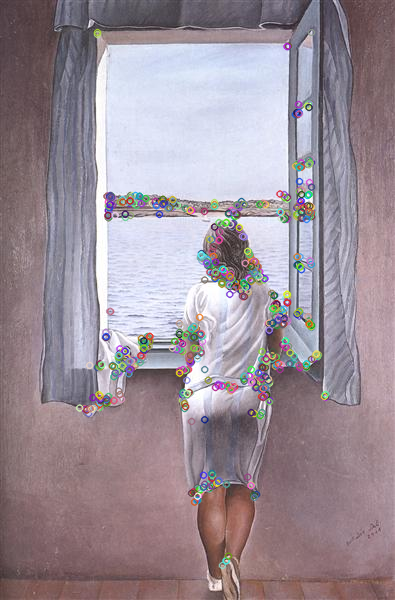

In [6]:
#TODO
#Draw keypoints
out = cv2.drawKeypoints(img,kp,None)
print('Image Keypoints')
display_img(out)

Image Rich Keypoints


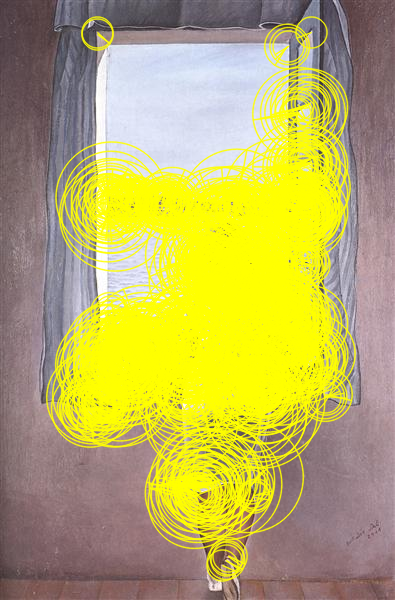

In [7]:
#TODO
#Draw rich keypoints
out = cv2.drawKeypoints(img,kp,None,(0,255,255),cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
print('Image Rich Keypoints')
display_img(out)

336
7.0
0
656
289
Features Matching


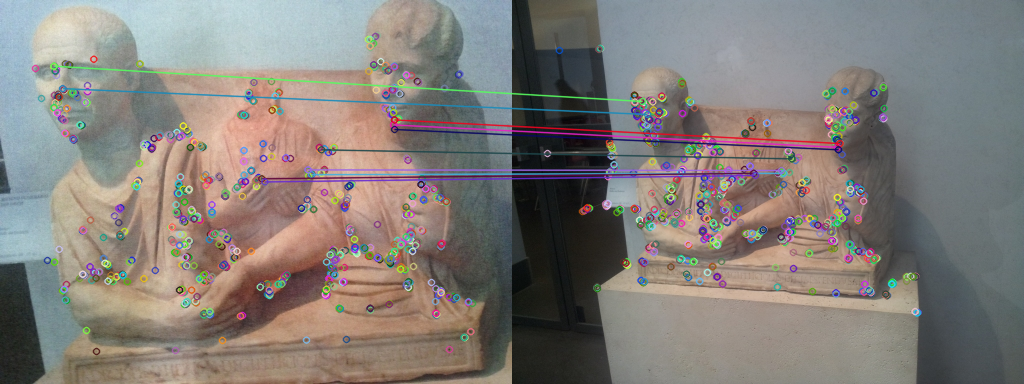

In [8]:
#TODO
img1 = cv2.imread(IMG_DIR + '/2014-05-14 14.52.14.jpg')
img2 = cv2.imread(IMG_DIR + '/20140512_105751.jpg')

#Extract ORB keypoints and features from img1 and img2
kp1, des1 = orb.detectAndCompute(img1, mask=None)
kp2, des2 = orb.detectAndCompute(img2, mask=None)

#Initialize matcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

#match features
matches = bf.match(des1, des2)

matches = sorted(matches, key=lambda x:x.distance)

#Draw matches
print(len(matches))
print(matches[0].distance)
print(matches[0].imgIdx)
print(matches[0].queryIdx)
print(matches[0].trainIdx)

img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None)
print('Features Matching')
display_img(img_matches)

115
Filtered Matching


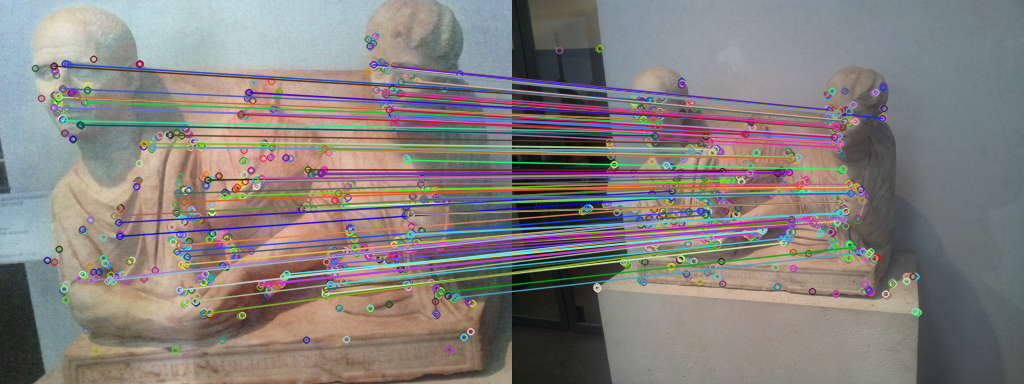

In [9]:
#TODO
#Set a good threshold
THRESHOLD = 35

#Filter good matches
good = [m for m in matches if m.distance<= THRESHOLD]
print(len(good))

#Draw good matches
good_matches = cv2.drawMatches(img1, kp1, img2, kp2, good, None)
print('Filtered Matching')
display_img(good_matches)

In [10]:
def add_bounding_box(img1, img2, kp1, kp2, good, M, mask, draw_inliers=False):
  matchesMask = mask.ravel().tolist()
  h, w, c = img1.shape
  pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
  dst = cv2.perspectiveTransform(pts, M)

  points = [np.int32(dst)]
  img2 = cv2.polylines(img2, points, isClosed=True, color=255, thickness=3, lineType=cv2.LINE_AA)
  if draw_inliers:
    draw_params = dict(matchColor=(0, 255, 0), # draw matches in green color
                       singlePointColor=None,
                       matchesMask=matchesMask, # draw only inliers
                       flags=2)
    return cv2.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)
  
  return img2

Ransac


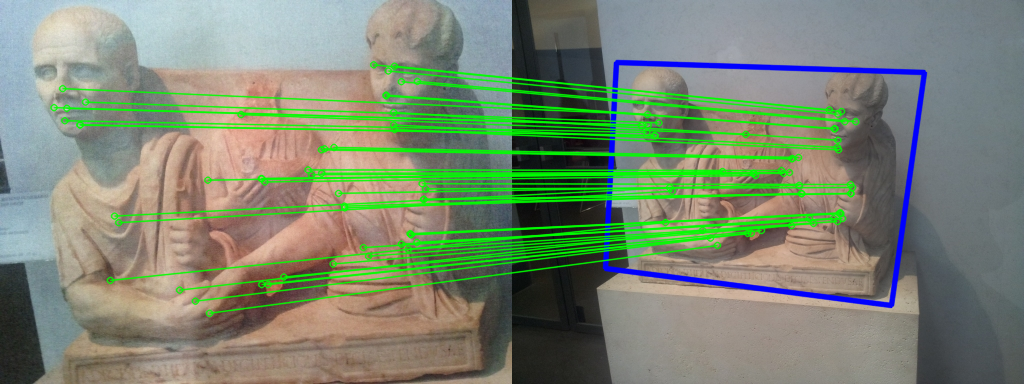

In [11]:
#TODO
#Select the points of the best matches
if len(good) > MIN_GOOD_MATCHES:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good])
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good])

#find homography
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 1.0)
    ransac_img = add_bounding_box(img1, img2, kp1, kp2, good, M, mask, True)
    print('Ransac')
    display_img(ransac_img)
else:
    print ("Not enough matches are found - %d/%d" % (len(good), MIN_GOOD_MATCHES))

In [12]:
#From https://github.com/juangallostra/augmented-reality

import math

class OBJ:
    def __init__(self, filename, swapyz=False):
        """Loads a Wavefront OBJ file. """
        self.vertices = []
        self.normals = []
        self.texcoords = []
        self.faces = []
        material = None
        for line in open(filename, "r"):
            if line.startswith('#'): continue
            values = line.split()
            if not values: continue
            if values[0] == 'v':
                v = list(map(float, values[1:4]))
                if swapyz:
                    v = v[0], v[2], v[1]
                self.vertices.append(v)
            elif values[0] == 'vn':
                v = list(map(float, values[1:4]))
                if swapyz:
                    v = v[0], v[2], v[1]
                self.normals.append(v)
            elif values[0] == 'vt':
                self.texcoords.append(map(float, values[1:3]))
            #elif values[0] in ('usemtl', 'usemat'):
                #material = values[1]
            #elif values[0] == 'mtllib':
                #self.mtl = MTL(values[1])
            elif values[0] == 'f':
                face = []
                texcoords = []
                norms = []
                for v in values[1:]:
                    w = v.split('/')
                    face.append(int(w[0]))
                    if len(w) >= 2 and len(w[1]) > 0:
                        texcoords.append(int(w[1]))
                    else:
                        texcoords.append(0)
                    if len(w) >= 3 and len(w[2]) > 0:
                        norms.append(int(w[2]))
                    else:
                        norms.append(0)
                #self.faces.append((face, norms, texcoords, material))
                self.faces.append((face, norms, texcoords))


def projection_matrix(camera_parameters, homography):
  """
  From the camera calibration matrix and the estimated homography
  compute the 3D projection matrix
  """
  # Compute rotation along the x and y axis as well as the translation
  homography = homography * (-1)
  rot_and_transl = np.dot(np.linalg.inv(camera_parameters), homography)
  col_1 = rot_and_transl[:, 0]
  col_2 = rot_and_transl[:, 1]
  col_3 = rot_and_transl[:, 2]
  # normalise vectors
  l = math.sqrt(np.linalg.norm(col_1, 2) * np.linalg.norm(col_2, 2))
  rot_1 = col_1 / l
  rot_2 = col_2 / l
  translation = col_3 / l
  # compute the orthonormal basis
  c = rot_1 + rot_2
  p = np.cross(rot_1, rot_2)
  d = np.cross(c, p)
  rot_1 = np.dot(c / np.linalg.norm(c, 2) + d / np.linalg.norm(d, 2), 1 / math.sqrt(2))
  rot_2 = np.dot(c / np.linalg.norm(c, 2) - d / np.linalg.norm(d, 2), 1 / math.sqrt(2))
  rot_3 = np.cross(rot_1, rot_2)
  # finally, compute the 3D projection matrix from the model to the current frame
  projection = np.stack((rot_1, rot_2, rot_3, translation)).T
  return np.dot(camera_parameters, projection)


def render(img, obj, projection, model, color=False):
    vertices = obj.vertices
    scale_matrix = np.eye(3) * 3
    h, w, c = model.shape

    for face in obj.faces:
        face_vertices = face[0]
        points = np.array([vertices[vertex - 1] for vertex in face_vertices])
        points = np.dot(points, scale_matrix)
        # render model in the middle of the reference surface. To do so,
        # model points must be displaced
        points = np.array([[p[0] + w / 2, p[1] + h / 2, p[2]] for p in points])
        dst = cv2.perspectiveTransform(points.reshape(-1, 1, 3), projection)
        imgpts = np.int32(dst)
        if color is False:
            cv2.fillConvexPoly(img, imgpts, (137, 27, 211))
        else:
            color = hex_to_rgb(face[-1])
            color = color[::-1] # reverse
            cv2.fillConvexPoly(img, imgpts, color)

    return img

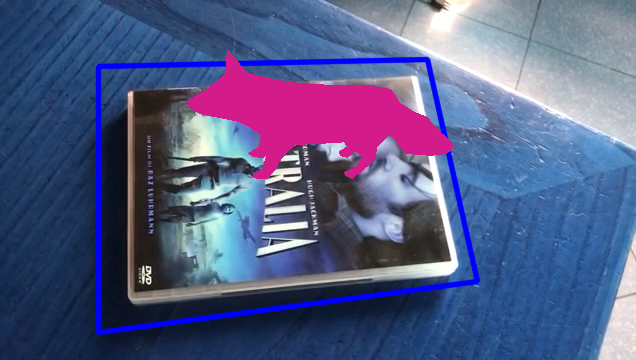

In [17]:
#TODO

VIDEO_SRC = IMG_DIR + '/australia.mp4'
CAMERA_SRC = 0
FRAMES_TO_SKIP = 5
OBJECT_IMG = IMG_DIR + '/australia.jpg'
MIN_RANSAC_INLIERS = 12

# TODO 
# read the query image OBJECT_IMG
img_q = cv2.imread(OBJECT_IMG)

# detect keypoints and extract features from query image
kp_q, des_q = orb.detectAndCompute(img_q, mask=None)

frame_count = 0

#vs = VideoStream(src=0).start() #webcam
vs = FileVideoStream(VIDEO_SRC).start()

# augmented reality
camera_parameters = np.array([[800, 0, 320], [0, 800, 240], [0, 0, 1]])
obj = OBJ(BASE_DIR + '/data/models/fox.obj', swapyz=True)

# loop over frames from the video file stream
while vs.more():

    # grab the frame from the threaded video stream
    frame = vs.read()

    if frame_count % FRAMES_TO_SKIP == 0:
      frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

      # TODO
      # detect keypoints and extract features from frame
      kp_f, des_f = orb.detectAndCompute(frame, mask=None)

      # match feautures with query
      matches_fq = bf.match(des_q, des_f)
      matches_fq = sorted(matches_fq, key=lambda x:x.distance)

      # select the good matches
      good_fq = [m for m in matches_fq if m.distance<= THRESHOLD]

      if len(good_fq) > MIN_GOOD_MATCHES:
        query_pts = np.float32([kp_q[m.queryIdx].pt for m in good_fq])
        frame_pts = np.float32([kp_f[m.trainIdx].pt for m in good_fq])

        # ransac & findHomography
        M_r, mask_r = cv2.findHomography(query_pts, frame_pts, cv2.RANSAC, 1.0)
    
        # show image with Homography and bounding box
        ransac_im = add_bounding_box(img_q, frame, kp_q, kp_f, good_fq, M_r, mask_r, True)

        # augmented reality
        projection = projection_matrix(camera_parameters, M_r)
        frame = render(frame, obj, projection, img_q, False)

        display_img(frame)
    frame_count += 1
